# 10/29

In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
from datetime import datetime

# Multi-task: reconsturction and variability prediction

### Data preprocessing

In [40]:
# Label encoder for variability type
label_encoder = LabelEncoder()

class LightCurveDataset(Dataset):
    def __init__(self, files, sequence_length=1000):
        self.files = files
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Load CSV file (skip metadata rows and set the right header)
        df = pd.read_csv(self.files[idx], skiprows=9)  # Skip the first 9 rows to start at data header

        # No normalization of StdMag to preserve its range and variability information
        stdmag = torch.tensor(df['StdMag'].values, dtype=torch.float32)  # Ensure Float32 dtype
        time_point = torch.tensor(df['Time'].values, dtype=torch.float32)
        
        # Pad or truncate sequences to fixed length
        seq_len = len(stdmag)
        if seq_len > self.sequence_length:
            start_idx = random.randint(0, seq_len - self.sequence_length)
            stdmag = stdmag[start_idx:start_idx + self.sequence_length]
            time_point = time_point[start_idx:start_idx + self.sequence_length]
            seq_len = self.sequence_length
        else:
            padding = self.sequence_length - seq_len
            stdmag = torch.cat([stdmag, torch.zeros(padding)])
            time_point = torch.cat([time_point, torch.zeros(padding)])

        # Variability type label (read from the 5th row as metadata)
        variability_type = pd.read_csv(self.files[idx], nrows=5).iloc[2, 1].split()[0]
        if int(variability_type) == 0:
            variability_type = 0
        elif int(variability_type) == 1 or int(variability_type) == 2:
            variability_type = 1
        label = torch.tensor(label_encoder.transform([variability_type])[0], dtype=torch.long)

        return stdmag, time_point, label
    
# Smoothing function
def smooth_curve(values, window_size=5):
    """Apply a moving average filter to smooth the curve."""
    if len(values) == 0:
        # Return the values unchanged if there are no elements
        return values
    
    if len(values) < window_size:
        # If the number of values is smaller than the window size, reduce the window size
        window_size = len(values)

    # Apply padding and smoothing
    padded_values = F.pad(values.unsqueeze(0), (window_size // 2, window_size // 2), mode='reflect').squeeze(0)
    smoothed_values = torch.conv1d(padded_values.unsqueeze(0).unsqueeze(0), torch.ones(1, 1, window_size) / window_size).squeeze()
    
    # Ensure the output length matches the input length by trimming any extra elements due to padding
    smoothed_values = smoothed_values[:len(values)]
    return smoothed_values


### Load Data

In [99]:
# Load data from CSV
data_dir = "data"
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]

# Step 1: Extract labels from CSV metadata and fit the LabelEncoder
variability_types = []

for file in files:
    metadata = pd.read_csv(file, nrows=5, header=None)
    variability = int(metadata.iloc[3, 1].split()[0])  # Read variability type from metadata
    if variability == 0:
        variability = 0
    elif variability == 1 or variability == 2:
        variability = 1
    variability_types.append(variability)

# Fit the LabelEncoder
label_encoder.fit(variability_types)

# Separate datasets
train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)
test_files = val_files

# Create separate datasets
train_dataset = LightCurveDataset(train_files)
val_dataset = LightCurveDataset(val_files)
test_dataset = LightCurveDataset(test_files)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Transformer Model

In [83]:
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim=128, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        # Initialize an empty positional encoding matrix with dimensions (max_len, hidden_dim)
        pe = torch.zeros(max_len, hidden_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Angular frequency (div_term)
        div_term = 1 / (1000 ** (2 * torch.arange(0, hidden_dim, 2).float() / hidden_dim))

        # Apply sine to even indices, cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term) # Even index dimensions
        pe[:, 1::2] = torch.cos(position * div_term) # Odd index dimensions

        # Add a batch dimension and transpose for compatibility
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input
        x = x + self.pe[:x.size(0), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, nhead=4, num_layers=2, hidden_dim=128, output_dim=2, max_len=1000):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim, max_len) #nn.Linear(1, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(hidden_dim, nhead, batch_first=True, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, time_diff):
        # Embed the StdMag values
        x = self.embedding(x.unsqueeze(-1))
        
        # Use time differences as positional encodings
        pos_enc = self.pos_encoder(time_diff.unsqueeze(-1))
        
        # Add positional encodings to input
        x = x + pos_enc
        
        # Pass through transformer layers
        x = self.transformer(x)
        
        # Classification output
        out = self.fc(x.mean(dim=1))
        return out

### CNN model

In [84]:
class CNNModel(nn.Module):
    def __init__(self, input_dim=1, num_classes=2):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64 * (1000 // 8), 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, _):
        x = x.unsqueeze(1)  # (batch_size, 1, seq_length)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### LSTM model

In [85]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, _):
        x = x.unsqueeze(-1)  # (batch_size, seq_length, 1)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take the output from the last time step
        return out

### GRU model

In [48]:
class GRUModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=2, output_dim=3):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, _):
        x = x.unsqueeze(-1)
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

### TST model

In [49]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, nhead=4, num_layers=2, hidden_dim=128, output_dim=3):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, _):
        x = self.embedding(x.unsqueeze(-1))
        x = self.transformer(x)
        x = self.fc(x.mean(dim=1))
        return x

### Additional settings

In [52]:
#LRScheduler
class LRScheduler():
    def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.patience,
            factor=self.factor,
            min_lr=self.min_lr,
            verbose=1
        )
    
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

#Early stopping
path = "models/model.pth"

class EarlyStopping():
    def __init__(self, patience=5, delta=0, verbose=1, path=path):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False #early stopping or not. default is False.
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            print(f'Early Stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Initialize early stopping
early_stopping = EarlyStopping(patience=5)

### Training - Transformer

In [107]:
path = "models/model_trans.pth"
# Initialize early stopping
early_stopping = EarlyStopping(patience=5, path=path)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Initialize model_TRANS
model_TRANS = TransformerModel()

# Lists to store the loss history
train_losses = []
val_losses = []
num_epochs = 100
alpha = 0.6  # Weighting factor between reconstruction and classification losses

# Loss functions and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_TRANS.parameters(), lr=0.001)

for epoch in range(100):
    model_TRANS.train()
    train_loss = 0.0

    # Training step
    for stdmag, time_point, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        output = model_TRANS(stdmag, time_point)

        # Smooth the actual StdMag values for the masked regions
        smoothed_stdmag = stdmag.clone()
        for i in range(stdmag.size(0)):  # Iterate over the batch
            smoothed_stdmag[i] = smooth_curve(stdmag[i])  # Smooth only masked parts

        # Compute loss
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        # Track losses
        train_loss += loss.item()

    # Average the losses
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model_TRANS.eval()
    val_loss = 0.0

    with torch.no_grad():
        for stdmag, time_point, labels in val_loader:
            output = model_TRANS(stdmag, time_point)

            # Smooth the actual StdMag values for validation masked regions
            smoothed_stdmag = stdmag.clone()
            for i in range(stdmag.size(0)):
                smoothed_stdmag[i] = smooth_curve(stdmag[i])

            loss = criterion(output, labels)

            val_loss += loss.item()

    # Average the validation losses
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Print loss information
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic (if implemented)
    early_stopping(val_loss, model=model_TRANS)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Evaluate the model_TRANS on the test set
all_labels_TRANS = []
all_preds_TRANS = []

model_TRANS.eval()  # Set the model_TRANS to evaluation mode
with torch.no_grad():
    for stdmag, time_point, labels in test_loader:
        output = model_TRANS(stdmag, time_point)
        preds = torch.argmax(output, dim=1)
        all_labels_TRANS.extend(labels.tolist())
        all_preds_TRANS.extend(preds.tolist())

Epoch 1, Train Loss: 0.8860, Val Loss: 0.7083
Validation loss decreased (inf --> 0.708263). Saving model ...
Epoch 2, Train Loss: 0.6967, Val Loss: 0.6705
Validation loss decreased (0.708263 --> 0.670535). Saving model ...
Epoch 3, Train Loss: 0.6718, Val Loss: 0.6579
Validation loss decreased (0.670535 --> 0.657895). Saving model ...
Epoch 4, Train Loss: 0.7124, Val Loss: 0.5885
Validation loss decreased (0.657895 --> 0.588530). Saving model ...
Epoch 5, Train Loss: 0.6051, Val Loss: 0.5256
Validation loss decreased (0.588530 --> 0.525642). Saving model ...
Epoch 6, Train Loss: 0.6006, Val Loss: 0.5439
Early Stopping counter: 1 out of 5
Epoch 7, Train Loss: 0.5915, Val Loss: 0.4729
Validation loss decreased (0.525642 --> 0.472862). Saving model ...
Epoch 8, Train Loss: 0.5804, Val Loss: 0.5069
Early Stopping counter: 1 out of 5
Epoch 9, Train Loss: 0.5919, Val Loss: 0.4866
Early Stopping counter: 2 out of 5
Epoch 10, Train Loss: 0.5895, Val Loss: 0.5288
Early Stopping counter: 3 out o

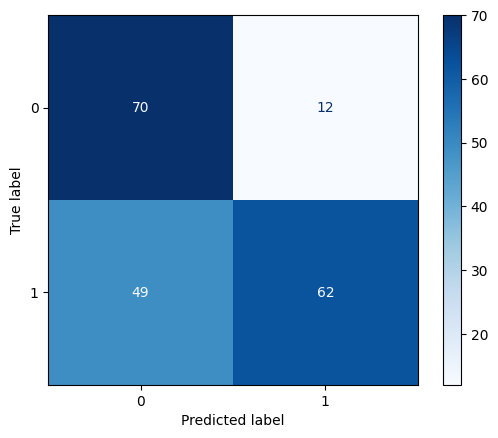

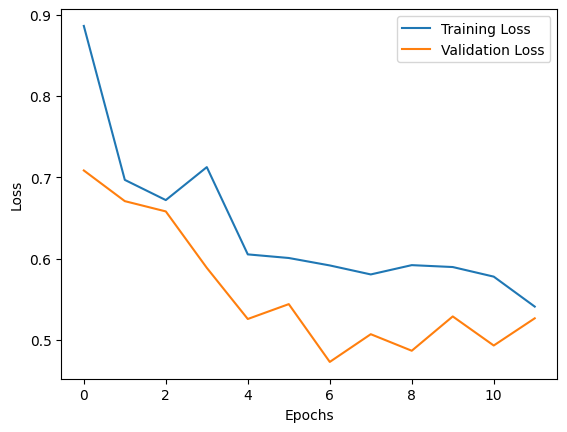

In [108]:
# Compute confusion matrix
cm = confusion_matrix(all_labels_TRANS, all_preds_TRANS)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Training - CNN

In [100]:
path = "models/model_CNN.pth"
# Initialize early stopping
early_stopping = EarlyStopping(patience=10, path=path)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Initialize model_CNN
model_CNN = CNNModel()

# Lists to store the loss history
train_losses_CNN = []
val_losses_CNN = []
num_epochs = 100

# Loss functions and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=0.001)

for epoch in range(200):
    model_CNN.train()
    train_loss = 0.0

    # Training step
    for stdmag, time_point, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        output = model_CNN(stdmag, time_point)

        # Smooth the actual StdMag values for the masked regions
        smoothed_stdmag = stdmag.clone()
        for i in range(stdmag.size(0)):  # Iterate over the batch
            smoothed_stdmag[i] = smooth_curve(stdmag[i])  # Smooth only masked parts

        # Compute loss
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        # Track losses
        train_loss += loss.item()

    # Average the losses
    train_loss /= len(train_loader)
    train_losses_CNN.append(train_loss)

    # Validation step
    model_CNN.eval()
    val_loss = 0.0

    with torch.no_grad():
        for stdmag, time_point, labels in val_loader:
            output = model_CNN(stdmag, time_point)

            # Smooth the actual StdMag values for validation masked regions
            smoothed_stdmag = stdmag.clone()
            for i in range(stdmag.size(0)):
                smoothed_stdmag[i] = smooth_curve(stdmag[i])

            loss = criterion(output, labels)

            val_loss += loss.item()

    # Average the validation losses
    val_loss /= len(val_loader)
    val_losses_CNN.append(val_loss)

    # Print loss information
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic (if implemented)
    early_stopping(val_loss, model=model_CNN)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Evaluate the model_CNN on the test set
all_labels_CNN = []
all_preds_CNN = []

model_CNN.eval()  # Set the model_CNN to evaluation mode
with torch.no_grad():
    for stdmag, time_point, labels in test_loader:
        output = model_CNN(stdmag, time_point)
        preds = torch.argmax(output, dim=1)
        all_labels_CNN.extend(labels.tolist())
        all_preds_CNN.extend(preds.tolist())

Epoch 1, Train Loss: 0.6445, Val Loss: 0.4881
Validation loss decreased (inf --> 0.488142). Saving model ...
Epoch 2, Train Loss: 0.5924, Val Loss: 0.4765
Validation loss decreased (0.488142 --> 0.476453). Saving model ...
Epoch 3, Train Loss: 0.5302, Val Loss: 0.4719
Validation loss decreased (0.476453 --> 0.471920). Saving model ...
Epoch 4, Train Loss: 0.5580, Val Loss: 0.5311
Early Stopping counter: 1 out of 10
Epoch 5, Train Loss: 0.5333, Val Loss: 0.4503
Validation loss decreased (0.471920 --> 0.450304). Saving model ...
Epoch 6, Train Loss: 0.4993, Val Loss: 0.4842
Early Stopping counter: 1 out of 10
Epoch 7, Train Loss: 0.4857, Val Loss: 0.5763
Early Stopping counter: 2 out of 10
Epoch 8, Train Loss: 0.5105, Val Loss: 0.4853
Early Stopping counter: 3 out of 10
Epoch 9, Train Loss: 0.4705, Val Loss: 0.5318
Early Stopping counter: 4 out of 10
Epoch 10, Train Loss: 0.4683, Val Loss: 0.4805
Early Stopping counter: 5 out of 10
Epoch 11, Train Loss: 0.4465, Val Loss: 0.5131
Early Sto

In [102]:
path = "models/model_CNN.pth"
# Load the best saved model before testing
loaded_CNN = CNNModel()  # Reinitialize the model structure
loaded_CNN.load_state_dict(torch.load(path))  # Load the saved weights
loaded_CNN.eval()  # Set to evaluation mode

# Evaluate the best model on the test set
all_labels_CNN = []
all_preds_CNN = []

with torch.no_grad():
    for stdmag, time_point, labels in test_loader:
        output = loaded_CNN(stdmag, time_point)
        preds = torch.argmax(output, dim=1)
        all_labels_CNN.extend(labels.tolist())
        all_preds_CNN.extend(preds.tolist())

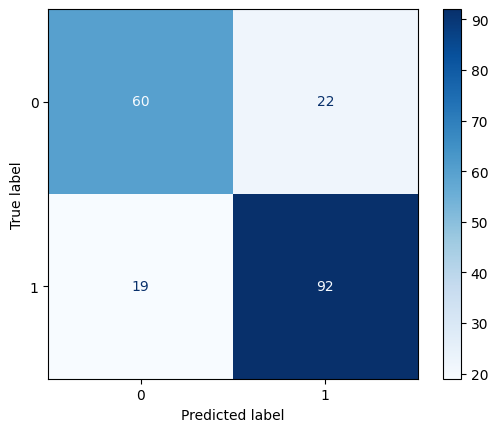

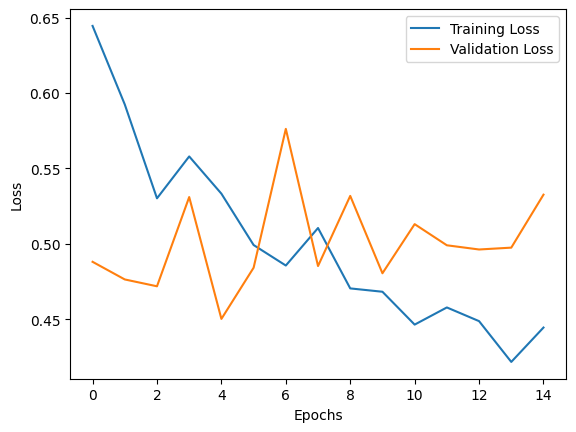

In [103]:
# Compute confusion matrix
cm = confusion_matrix(all_labels_CNN, all_preds_CNN)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

plt.plot(train_losses_CNN, label='Training Loss')
plt.plot(val_losses_CNN, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### training - LSTM

In [104]:
path = "models/model_LSTM.pth"
# Initialize early stopping
early_stopping = EarlyStopping(patience=10, path=path)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Initialize model_LSTM
model_LSTM = LSTMModel()

# Lists to store the loss history
train_losses_LSTM = []
val_losses_LSTM = []
num_epochs = 100

# Loss functions and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=0.001)

for epoch in range(200):
    model_LSTM.train()
    train_loss = 0.0

    # Training step
    for stdmag, time_point, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        output = model_LSTM(stdmag, time_point)

        # Smooth the actual StdMag values for the masked regions
        smoothed_stdmag = stdmag.clone()
        for i in range(stdmag.size(0)):  # Iterate over the batch
            smoothed_stdmag[i] = smooth_curve(stdmag[i])  # Smooth only masked parts

        # Compute loss
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        # Track losses
        train_loss += loss.item()

    # Average the losses
    train_loss /= len(train_loader)
    train_losses_LSTM.append(train_loss)

    # Validation step
    model_LSTM.eval()
    val_loss = 0.0

    with torch.no_grad():
        for stdmag, time_point, labels in val_loader:
            output = model_LSTM(stdmag, time_point)

            # Smooth the actual StdMag values for validation masked regions
            smoothed_stdmag = stdmag.clone()
            for i in range(stdmag.size(0)):
                smoothed_stdmag[i] = smooth_curve(stdmag[i])

            loss = criterion(output, labels)

            val_loss += loss.item()

    # Average the validation losses
    val_loss /= len(val_loader)
    val_losses_LSTM.append(val_loss)

    # Print loss information
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic (if implemented)
    early_stopping(val_loss, model=model_LSTM)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Evaluate the model_LSTM on the test set
all_labels_LSTM = []
all_preds_LSTM = []

model_LSTM.eval()  # Set the model_LSTM to evaluation mode
with torch.no_grad():
    for stdmag, time_point, labels in test_loader:
        output = model_LSTM(stdmag, time_point)
        preds = torch.argmax(output, dim=1)
        all_labels_LSTM.extend(labels.tolist())
        all_preds_LSTM.extend(preds.tolist())

Epoch 1, Train Loss: 0.6284, Val Loss: 0.5312
Validation loss decreased (inf --> 0.531236). Saving model ...
Epoch 2, Train Loss: 0.5882, Val Loss: 0.5257
Validation loss decreased (0.531236 --> 0.525714). Saving model ...
Epoch 3, Train Loss: 0.5931, Val Loss: 0.5257
Validation loss decreased (0.525714 --> 0.525658). Saving model ...
Epoch 4, Train Loss: 0.5873, Val Loss: 0.5253
Validation loss decreased (0.525658 --> 0.525318). Saving model ...
Epoch 5, Train Loss: 0.5868, Val Loss: 0.5239
Validation loss decreased (0.525318 --> 0.523876). Saving model ...
Epoch 6, Train Loss: 0.5795, Val Loss: 0.5269
Early Stopping counter: 1 out of 10
Epoch 7, Train Loss: 0.5774, Val Loss: 0.5189
Validation loss decreased (0.523876 --> 0.518898). Saving model ...
Epoch 8, Train Loss: 0.5800, Val Loss: 0.5372
Early Stopping counter: 1 out of 10
Epoch 9, Train Loss: 0.5877, Val Loss: 0.5197
Early Stopping counter: 2 out of 10
Epoch 10, Train Loss: 0.5820, Val Loss: 0.5198
Early Stopping counter: 3 ou

In [105]:
path = "models/model_LSTM.pth"
# Load the best saved model before testing
loaded_LSTM = LSTMModel()  # Reinitialize the model structure
loaded_LSTM.load_state_dict(torch.load(path))  # Load the saved weights
loaded_LSTM.eval()  # Set to evaluation mode

# Evaluate the best model on the test set
all_labels_LSTM = []
all_preds_LSTM = []

with torch.no_grad():
    for stdmag, time_point, labels in test_loader:
        output = loaded_LSTM(stdmag, time_point)
        preds = torch.argmax(output, dim=1)
        all_labels_LSTM.extend(labels.tolist())
        all_preds_LSTM.extend(preds.tolist())

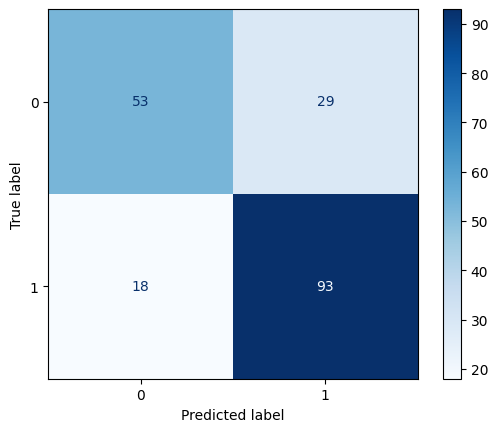

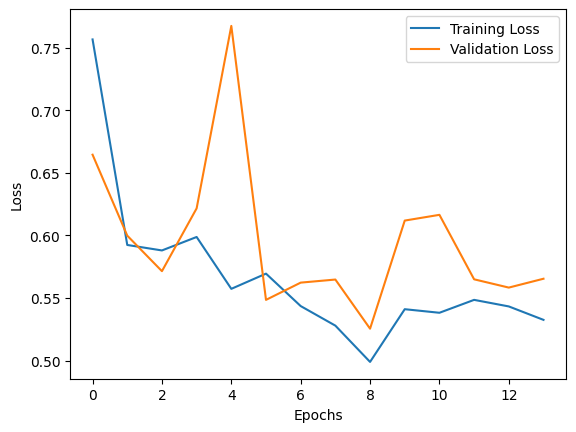

In [106]:
# Compute confusion matrix
cm = confusion_matrix(all_labels_LSTM, all_preds_LSTM)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### GRU model

In [109]:
path = "models/model_GRU.pth"
# Initialize early stopping
early_stopping = EarlyStopping(patience=10, path=path)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Initialize model_GRU
model_GRU = GRUModel()

# Lists to store the loss history
train_losses_GRU = []
val_losses_GRU = []

# Loss functions and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=0.001)

for epoch in range(200):
    model_GRU.train()
    train_loss = 0.0

    # Training step
    for stdmag, time_point, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        output = model_GRU(stdmag, time_point)

        # Smooth the actual StdMag values for the masked regions
        smoothed_stdmag = stdmag.clone()
        for i in range(stdmag.size(0)):  # Iterate over the batch
            smoothed_stdmag[i] = smooth_curve(stdmag[i])  # Smooth only masked parts

        # Compute loss
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        # Track losses
        train_loss += loss.item()

    # Average the losses
    train_loss /= len(train_loader)
    train_losses_GRU.append(train_loss)

    # Validation step
    model_GRU.eval()
    val_loss = 0.0

    with torch.no_grad():
        for stdmag, time_point, labels in val_loader:
            output = model_GRU(stdmag, time_point)

            # Smooth the actual StdMag values for validation masked regions
            smoothed_stdmag = stdmag.clone()
            for i in range(stdmag.size(0)):
                smoothed_stdmag[i] = smooth_curve(stdmag[i])

            loss = criterion(output, labels)

            val_loss += loss.item()

    # Average the validation losses
    val_loss /= len(val_loader)
    val_losses_GRU.append(val_loss)

    # Print loss information
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic (if implemented)
    early_stopping(val_loss, model=model_GRU)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Evaluate the model_GRU on the test set
all_labels_GRU = []
all_preds_GRU = []

model_GRU.eval()  # Set the model_GRU to evaluation mode
with torch.no_grad():
    for stdmag, time_point, labels in test_loader:
        output = model_GRU(stdmag, time_point)
        preds = torch.argmax(output, dim=1)
        all_labels_GRU.extend(labels.tolist())
        all_preds_GRU.extend(preds.tolist())

Epoch 1, Train Loss: 0.7354, Val Loss: 0.5419
Validation loss decreased (inf --> 0.541865). Saving model ...
Epoch 2, Train Loss: 0.6062, Val Loss: 0.5299
Validation loss decreased (0.541865 --> 0.529868). Saving model ...
Epoch 3, Train Loss: 0.5860, Val Loss: 0.5319
Early Stopping counter: 1 out of 10
Epoch 4, Train Loss: 0.5937, Val Loss: 0.5743
Early Stopping counter: 2 out of 10
Epoch 5, Train Loss: 0.6136, Val Loss: 0.5435
Early Stopping counter: 3 out of 10
Epoch 6, Train Loss: 0.5897, Val Loss: 0.5244
Validation loss decreased (0.529868 --> 0.524369). Saving model ...
Epoch 7, Train Loss: 0.5895, Val Loss: 0.5286
Early Stopping counter: 1 out of 10
Epoch 8, Train Loss: 0.5797, Val Loss: 0.5241
Validation loss decreased (0.524369 --> 0.524129). Saving model ...
Epoch 9, Train Loss: 0.5743, Val Loss: 0.5171
Validation loss decreased (0.524129 --> 0.517063). Saving model ...
Epoch 10, Train Loss: 0.5963, Val Loss: 0.5435
Early Stopping counter: 1 out of 10
Epoch 11, Train Loss: 0.

In [110]:
path = "models/model_GRU.pth"
# Load the best saved model before testing
loaded_GRU = GRUModel()  # Reinitialize the model structure
loaded_GRU.load_state_dict(torch.load(path))  # Load the saved weights
loaded_GRU.eval()  # Set to evaluation mode

# Evaluate the best model on the test set
all_labels_GRU = []
all_preds_GRU = []

with torch.no_grad():
    for stdmag, time_point, labels in test_loader:
        output = loaded_GRU(stdmag, time_point)
        preds = torch.argmax(output, dim=1)
        all_labels_GRU.extend(labels.tolist())
        all_preds_GRU.extend(preds.tolist())

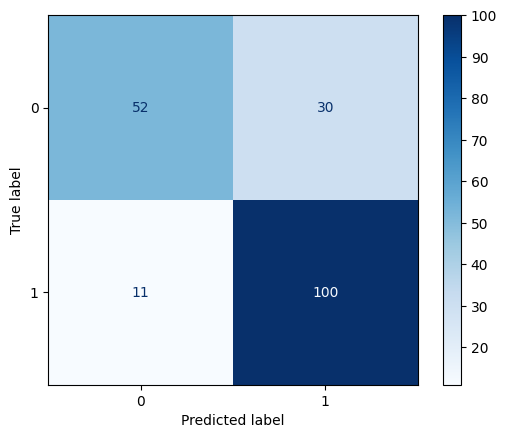

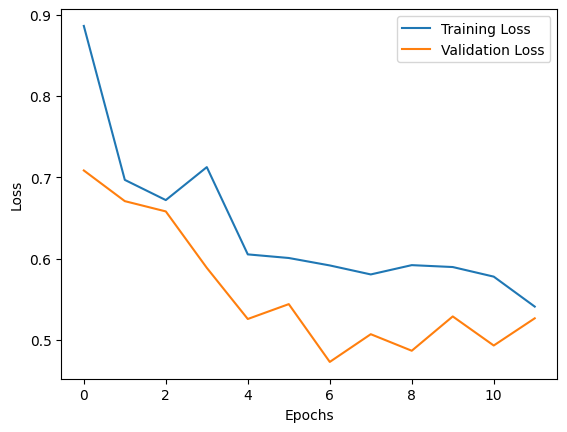

In [111]:
# Compute confusion matrix
cm = confusion_matrix(all_labels_GRU, all_preds_GRU)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()